# Car evaluations classification

## Setup

Importing necessary libraries for the analysis

In [1]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn import tree,linear_model,neighbors, datasets
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction import DictVectorizer
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
# Ignoring warnings for clean output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Loading, exploring & Transforming the data

In [43]:
data = pd.read_csv('car.data', header = None)
n_samples, n_features = data.shape
print ('The dimensions of the data set are', n_samples, 'samples by', n_features,'features.')

The dimensions of the data set are 1728 samples by 7 features.


In [44]:
# Assigning names to the columns in the dataset
data.columns = ['Price', 'Maintenance Cost', 'Number of Doors', 'Capacity', 'Size of Luggage Boot', 'safety', 'Decision']
data.sample(10)

,Price,Maintenance Cost,Number of Doors,Capacity,Size of Luggage Boot,safety,Decision
1515,low,med,2,2,med,low,unacc
572,high,high,3,2,med,high,unacc
1500,low,high,5more,4,big,low,unacc
1332,low,vhigh,3,4,small,low,unacc
868,med,vhigh,2,2,med,med,unacc
555,high,high,2,4,big,low,unacc
871,med,vhigh,2,2,big,med,unacc
803,high,low,3,more,small,high,acc
1620,low,low,2,2,small,low,unacc
1449,low,high,3,more,small,low,unacc


## Ordinal Encoding

First converting the ordinal variables into numeric for our analysis. We will also be converting them to categorical data using One Hot encoding for the best model and comparing the performance later.

For now, first converting to numerical data because logically the classes can be given an order. And based on some business knowledge we know that vhigh is greater than high and med is greater than low, etc. 

In [45]:
# label Encoding
# Replacing with numerical data as they are ordinal variables
data['Price'].replace(('low', 'med', 'high', 'vhigh'), (0, 1, 2, 3), inplace = True)
data['Maintenance Cost'].replace(('low', 'med', 'high', 'vhigh'), (0, 1, 2, 3), inplace = True)
data['Number of Doors'].replace('5more', 5, inplace = True)
data['Capacity'].replace('more', 5, inplace = True)
data['safety'].replace(('low', 'med', 'high'), (0, 1, 2), inplace = True)
data['Size of Luggage Boot'].replace(('small', 'med', 'big'), (0, 1, 2), inplace = True)
data['Decision'].replace(('unacc', 'acc', 'good', 'vgood'), (0, 1, 2, 3), inplace = True)

Sample of the data after Numerical Ordinal encoding of the data

In [46]:
data.sample(10)

,Price,Maintenance Cost,Number of Doors,Capacity,Size of Luggage Boot,safety,Decision
1690,0,0,4,4,2,1,2
619,2,2,4,5,2,1,1
348,3,0,2,5,2,0,0
1469,0,2,4,4,0,2,1
1216,1,0,3,2,0,1,0
15,3,3,2,4,2,0,0
178,3,2,4,4,2,1,0
1583,0,1,4,4,2,2,3
1204,1,0,2,4,2,1,2
857,2,0,5,5,0,2,1


In [47]:
# splitting the dataset into predictors(x) and target(y) variables

x = data.iloc[:,:6]
y = data.iloc[:, 6]

print("Shape of x: ", x.shape)
print("Shape of y: ", y.shape)

Shape of x:  (1728, 6)
Shape of y:  (1728,)


## Train, Validation and Test splits

In [48]:
#setting 20% aside as testing data for final evaluation of our model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 45, stratify = y)

#setting 20% aside as validation data for cross validation
x_train_t, x_train_v, y_train_t, y_train_v = train_test_split(x_train, y_train, test_size = 0.20, random_state = 45, stratify = y_train)

In [49]:
#checking if sampling is stratified
y_test.value_counts() / y.value_counts()

0    0.200000
1    0.200521
2    0.202899
3    0.200000
Name: Decision, dtype: float64

## 1. Logistic Regression

### Modeling

As a starting point, we run the default Logistic regression classifer.

In [10]:
# creating a model
# since the classes are not balanced, using class_weight = weighted
model = linear_model.LogisticRegression(class_weight="balanced")
# feeding the training data into the model
model.fit(x_train, y_train)

# predicting the values for x-test
y_pred = model.predict(x_test)

# finding the training and testing accuracy
print("Training Accuracy: {0:.2%}".format(model.score(x_train, y_train)))
print("Testing Accuracy: {0:.2%}".format(model.score(x_test, y_test)))
print()
# printing the confusion Matrix
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))

Training Accuracy: 84.15%
Testing Accuracy: 86.71%

Confusion Matrix: - 
 [[218   8  11   5]
 [ 12  60   4   1]
 [  0   0  14   0]
 [  0   2   3   8]]


### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross validation with grid search with the following hyper parameters. 

1. solver : Among the various solvers available for multi-class classification, we see what would be the best for our model - 'newton-cg', 'lbfgs', 'sag', 'saga'
2. C : We also check what is an optimal value for regularization strength. The hyper-parameter 'C' is 1 / lambda (which is an inverse of the penalty or regularization strength.

We also set the hyper parameters multi_class = auto as it is a multiclass classification problem. And we use penalty = l2 for regularization.

I have decided to use scoring as **micro-avergaed f1 score** in the grid search cross validation because:-
1. f1 score is a better metric to determine a good model as it is the harmonic mean of precision and recall.
2. micro averaged f1 score tunes grid search to predict well for all classes as it calculates metrics globally by counting the total true positives, false negatives and false positives.



In [11]:
grid_values = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], \
              'C':[1e-4,0.001,.009,0.01,.09,1,5,10,25,100,1000,1e4]}

clf = linear_model.LogisticRegression(class_weight="balanced", multi_class='auto', penalty = 'l2', random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_logit = GridSearchCV(clf, grid_values, cv = inner_cv, scoring='f1_micro',n_jobs=-1)
grid_logit.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_logit, x_train, y_train, cv=outer_cv)

In [12]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_logit.best_params_)
print()
print ("The best logistic regression classifier is :-\n", grid_logit.best_estimator_)
y_pred = grid_logit.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 83.00% +/- 1.02%

The best hyper-parameters to get these accuracy are :-
 {'C': 25, 'solver': 'newton-cg'}

The best logistic regression classifier is :-
 LogisticRegression(C=25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=45,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix: - 
 [[208  22   9   3]
 [  7  64   3   3]
 [  0   2  11   1]
 [  0   1   1  11]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       242
           1       0.72      0.83      0.77        77
           2       0.46      0.79      0.58        14
           3       0.61      0.85      0.71        13

   micro avg       0.85      0.85      0.85       346
   macro avg       0.69      0.83      0.74       346
weighted av

### Goodness of fit

Logistic regression grid search with nested cross validation tells us that the best parameters are **C: 25, penalty: 'l2', solver: 'newton-cg'**

To avoid overfitting, we use regularization by a L2 penalty and a C parameter value = 25.


With this, we get an accuracy of 83.00% +/- 1.02% which is quite low, and the standard deviation in accuracy is high, which indicates that the model is not generalized well.

The prevision and recall vary for various classes and hence it is meaningful to ook at the f1-scores, which is good for classe unacceptable (0), but low for the other classes. The micro avg f1-score is 85% between all classes.

## 2.Decision Trees 

### Modeling

Initialized the default Decision tree classifier.

In [13]:
# creating a model
model = tree.DecisionTreeClassifier(class_weight="balanced")
# feeding the training data into the model
model.fit(x_train, y_train)

# predicting the values for x-test
y_pred = model.predict(x_test)

# finding the training and testing accuracy
print("Training Accuracy: ",model.score(x_train, y_train))
print("Testing Accuracy: ", model.score(x_test, y_test))

# printing the confusion Matrix
#plot_confusion_matrix(y_test, y_pred, classes=['unacc', 'acc', 'good', 'vgood'],
#                      title='Confusion matrix - Decision Tree')
print("Classification Report: - \n",classification_report(y_test, y_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.9913294797687862
Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       242
           1       0.97      0.99      0.98        77
           2       1.00      1.00      1.00        14
           3       0.93      1.00      0.96        13

   micro avg       0.99      0.99      0.99       346
   macro avg       0.98      0.99      0.98       346
weighted avg       0.99      0.99      0.99       346



Here we get a trainign accuracy of 100% and testing accuracy of 98%. Even though the difference is not that high, a traning accuracy of 100% is an indication of overfitting, so looking at tuning the model so that the trianing accuracy is close to the testing accuracy.

### Tuning the hyper-parameters

Now we see what is the best max-depth for maximizing accuracy in the test data.

The max-depth of a tree defines the number of features used to classify the data. Using very few features would result in underfitting and using a lot of features would lead to over-fitting.

We also look at both criterions gini and entropy to see which gives us a better accuracy

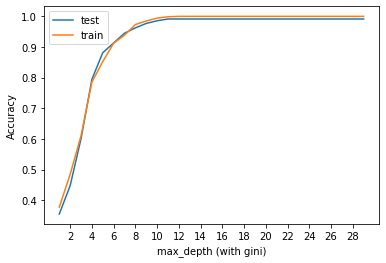

In [14]:
complexity_values = range(1,30)

train_accuracies = []
test_accuracies=[]

for complexity_value in complexity_values:
    clf = tree.DecisionTreeClassifier(class_weight="balanced",criterion="gini", max_depth=complexity_value)
    test_accuracies.append(clf.fit(x_train, y_train).score(x_test, y_test))
    train_accuracies.append(clf.fit(x_train, y_train).score(x_train, y_train))
    
# We want to plot our results
line1, =plt.plot(complexity_values, test_accuracies,label='test_accuracies')
line2, =plt.plot(complexity_values, train_accuracies,label='train_accuracies')
plt.xlabel("max_depth (with gini)")
plt.ylabel("Accuracy")
plt.xticks(range(2,30,2))
plt.legend((line1, line2), ('test', 'train'))
plt.show()

Here we can see that a max depth = 10 and gini scoring method has a good tradeoff between high accuracy and low variation between training and testing data, but this can be further tuned with grid search nested cross validation.

## Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross-validation grid search with the following hyper parameters

1. criterion : to find an optimal criterion to calculate impurity of a node
2. max_depth : to search for the optimal number of features used for classification. Setting the right value for the max_depth (i.e. the number of features used for classification) is crucial to avoid overfitting or underfitting
3. min_samples_leaf : to search for the optimal minimum number of samples required to form a leaf
4. min_impurity_decrease : to search for the optimal minimum impurity decrease to split a node. If this split induces a decrease of the impurity greater than or equal to min_impurity_decrease only then the split will happen. This prevents splits where information gain is very low.

I have decided to use scoring as micro-avergaed f1 score in the grid search cross validation because:-

1. f1 score is a better metric to determine a good model as it is the harmonic mean of precision and recall.
2. micro averaged f1 score tunes grid search to predict well for all classes as it calculates metrics globally by counting the total true positives, false negatives and false positives.

In [15]:
param_grid = dict(criterion = ["gini", "entropy"], 
                  max_depth = range(2,10),
                  min_samples_leaf = range(2,8),
                  min_impurity_decrease = [0,1e-8,1e-7,1e-6,1e-5,1e-4]
                 )

grid_tree_clf = tree.DecisionTreeClassifier(class_weight="balanced",random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_tree = GridSearchCV(grid_tree_clf, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_tree.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_tree, x_train, y_train, cv=outer_cv)

In [16]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_tree.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_tree.best_estimator_)
y_pred = grid_tree.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 96.89% +/- 0.74%

The best hyper-parameters to get these accuracy are :-
 {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 2}

The best decision tree classifier is :-
 DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')
Confusion Matrix: - 
 [[236   6   0   0]
 [  1  73   2   1]
 [  0   0  14   0]
 [  0   0   0  13]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       242
           1       0.92      0.95      0.94        77
           2       0.88      1.00      0.93        14
           3       0.93      1.00      0.96    

### Goodness of fit

Decision tree grid search with nested cross validation tells us that the best parameters for decision tree classification are  are criterion: 'gini', max_depth: 9, min_impurity_decrease: 0, min_samples_leaf: 2

To avoid overfitting, we use max depth as 9, and we saw a similar pattern in the graph above.

With this, we get an accuracy of 96.89% +/- 0.74% which is much higher than the accuracy of logistic regression model. The standard deviation in accuracy is low, which indicates that the model is generalized well.

The prevision and recall vary for various classes but not as much as they did in logistic regression but it is still meaningful to look at the f1-scores which are good for most of the classes, but relatively low for class 2 at 93%. The micro avg f1-score is 97% which is the best we have got so far.

### Prediction between classes

1. Class 0 has a high precision and recall of 100% and 98% respectively. There are only 6 unacceptable cars missclassified  which is okay considering 236 are identified correctly.
2. CLass 1 has a good precision and recall. There are 4 cars in class 1 which are misclassified and there are 6 cars classified as 1 which are not. This might be reason for problem.
3. Class 2 has 2 cars classified as 2 inaccurately.
4. This Model has predicted extremely well for class 3, with all 13 identified correctly (recall = 100%).

Therefore, the Decision Tree classifier predicts really well for all classes but slightly lower of 1 and 2.

## 3. K-Nearest Neighbours

### Modeling

We start by runnng the default KNeighborsClassifier classifier.

In [51]:
model = neighbors.KNeighborsClassifier()

# feeding the training data into the model
model.fit(x_train, y_train)

# predicting the values for x-test
y_pred = model.predict(x_test)

# finding the training and testing accuracy
print("Training Accuracy: ",model.score(x_train, y_train))
print("Testing Accuracy: ", model.score(x_test, y_test))
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
# printing the confusion Matrix
#plot_confusion_matrix(y_test, y_pred, classes=['unacc', 'acc', 'good', 'vgood'],
#                      title='Confusion matrix - KNN')
print("Classification Report: - \n",classification_report(y_test, y_pred))

Training Accuracy:  0.983357452966715
Testing Accuracy:  0.9566473988439307

Confusion Matrix: - 
 [[237   5   0   0]
 [  4  73   0   0]
 [  0   4  10   0]
 [  0   2   0  11]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       242
           1       0.87      0.95      0.91        77
           2       1.00      0.71      0.83        14
           3       1.00      0.85      0.92        13

   micro avg       0.96      0.96      0.96       346
   macro avg       0.96      0.87      0.91       346
weighted avg       0.96      0.96      0.96       346



Here we get a training accuracy of 98% and testing accuracy of 95%. This is a significant differnece between trianing and testing accuracies and might be an indication of overfitting, so looking at tuning the model so that the trianing accuracy is close to the testing accuracy.

### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a grid search with the following hyper parameters

weights : To check whether assigneing uniform weights or weights based on distance give a us better model.
n_neighbors : As defined earlier, it is crucial to select an optimal number of neighbours to run the classification model.

I have decided to use scoring as micro-avergaed f1 score in the grid search cross validation as explained in the previous models

In [50]:
k_range = list(range(1,30))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)

grid_knn_clf = neighbors.KNeighborsClassifier()

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_knn = GridSearchCV(grid_knn_clf, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_knn.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_knn, x_train, y_train, cv=outer_cv)

In [19]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_knn.best_params_)
print()
print ("The best KNN classifier is :-\n", grid_knn.best_estimator_)
y_pred = grid_knn.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 94.14% +/- 0.83%

The best hyper-parameters to get these accuracy are :-
 {'n_neighbors': 6, 'weights': 'distance'}

The best KNN classifier is :-
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')

Confusion Matrix: - 
 [[237   5   0   0]
 [  3  73   1   0]
 [  0   2  12   0]
 [  0   2   1  10]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       242
           1       0.89      0.95      0.92        77
           2       0.86      0.86      0.86        14
           3       1.00      0.77      0.87        13

   micro avg       0.96      0.96      0.96       346
   macro avg       0.93      0.89      0.91       346
weighted avg       0.96      0.96      0.96       346



### Goodness of fit

K Nearest Neighbours with nested cross validation tells us that the best parameters are 5 neighbours with a weighted distance.

With this, we get an accuracy of 94.14% +/- 0.83% which is a lower accuracy and higher standard deviation as compared to decision tree classifier.

The f1-score varies for various classes and the micro avg f1 score is 96% which is lower than Decision Tree Classifier.

## 4. SVM

For support vector classification, we want to check if linear or rbf kernal provides us a better perfromance so I am running a nested cross validation with grid search.

### Tuning parameters - Nested CV & Grid search

To search for the best parameters, we run a nested cross validation with grid search with the following hyper parameters

1. C: This heps us introduce soft margin to the SVM classification, allowing for outliers. Larger the C, smaller number of errors are allowed. It is a way of controlling overfitting - by making C smaller, we allow some outliers

2. gamma: For the gaussian rbf kernel trick, we cna specify the number of neighbours that the svm classifier will look at for deciding the boundaires. A large gamma value indicates looking at few neighbours and cna lead to overfitting the model. A small gamma value leads to looking at a large number of neighbours.

3. kernel trick: for data points that are linearly seperable, we can use the linear kernel and rbf kernel is for guassian distribution. We add these to the gridsearch to see which is better for our classification problem.

4. decision_function_shape: Since this is a multiclass classification, we need to specify to SVC whether we want the classes compared one over the rest or one over one so we use this also in our grid search.

In [52]:
# standardization for svc
sc = StandardScaler()
x_train_t = sc.fit_transform(x_train_t)
x_test = sc.transform(x_test)

C:\Users\harsh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\harsh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\harsh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [53]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear','rbf']
dfs = ['ovr','ovo']
param_grid = {'kernel':kernels,'C': Cs, 'gamma' : gammas, 'decision_function_shape' :dfs}

model = SVC(class_weight="balanced",probability=True,random_state = 45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_svm = GridSearchCV(model, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_svm.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_svm, x_train, y_train, cv=outer_cv)

In [22]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_svm.best_params_)
print()
print ("The best SVM classifier is :-\n", grid_svm.best_estimator_)
y_pred = grid_svm.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 97.97% +/- 0.61%

The best hyper-parameters to get these accuracy are :-
 {'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}

The best SVM classifier is :-
 SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=45, shrinking=True,
  tol=0.001, verbose=False)
Confusion Matrix: - 
 [[238   4   0   0]
 [  1  76   0   0]
 [  0   1  13   0]
 [  0   0   0  13]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       242
           1       0.94      0.99      0.96        77
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        13

   micro avg       0.98      0.98      0.98       346
   macro avg       0.98      0.97      0.98       346
weighted avg       0.98      0.

### Goodness of fit

SVM with nested cross validation tells us that the best parameters are 'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'

With this, we get an accuracy of 97.97% +/- 0.61% which is the best so far.

The f1-score varies for various classes but highest so far. It is pretty great for classes 0,3 but only good for 1,2. However, the micro avg f1 score is 98% which is the best so far.

### Prediction between classes

1. Class 0 has a high precision and recall of 100% and 98% respectively. There are only 4 unacceptable cars missclassified  which is okay considering 238 are identified correctly.
2. Most cars in  Class 1 were identified correctly, with recall = 99% but there are 5 cars identified as class 1 where they are not.
3. Class 2 has only 1 missclassified car .
4. This Model has predicted well for class 3, with all 13 identified correctly, and none identified inaccurately as class 3.

Therefore, SVM predicts really well for all classes.

## 5. Naive Bayes Classifier

In [23]:
model = GaussianNB()

# feeding the training data into the model
model.fit(x_train, y_train)

# predicting the values for x-test
y_pred = model.predict(x_test)

# finding the training and testing accuracy
print("Training Accuracy: ",model.score(x_train, y_train))
print("Testing Accuracy: ", model.score(x_test, y_test))
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()

Training Accuracy:  0.7756874095513748
Testing Accuracy:  0.6994219653179191

Confusion Matrix: - 
 [[242   0   0   0]
 [ 77   0   0   0]
 [ 14   0   0   0]
 [ 13   0   0   0]]



This has a very low accuracy compared to all the classifiers.

## One Hot Encoding

SInce the Decision Tree Classifier and SVM have provided us the best results so far, with SVM having a higher accuracy and f1-score but decision tree having a more smooth standard deviation of accuracy in nested cross validation, we do one hot encoding on the dataset and run it on both these classifiers again using nested cross validation GridSearch.

When we do this transformation, we get an increased number of features.

In [24]:
data = pd.read_csv('car.data', header = None)
data.columns = ['Price', 'Maintenance Cost', 'Number of Doors', 'Capacity', 'Size of Luggage Boot', 'safety', 'Decision']

In [25]:
enc = OneHotEncoder(categories='auto')
enc.fit(data.iloc[:,:6])

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [26]:
enc.categories_

[array(['high', 'low', 'med', 'vhigh'], dtype=object),
 array(['high', 'low', 'med', 'vhigh'], dtype=object),
 array(['2', '3', '4', '5more'], dtype=object),
 array(['2', '4', 'more'], dtype=object),
 array(['big', 'med', 'small'], dtype=object),
 array(['high', 'low', 'med'], dtype=object)]

In [27]:
x_c = pd.DataFrame(enc.transform(data.iloc[:,:6]).toarray())

In [28]:
x_c.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [29]:
data['Decision'].replace(('unacc', 'acc', 'good', 'vgood'), (0, 1, 2, 3), inplace = True)

In [30]:
y_c = data['Decision']

## Train-Validation-Test Split

In [54]:
#setting 20% aside as testing data for final evaluation of our model
x_train, x_test, y_train, y_test = train_test_split(x_c, y_c, test_size = 0.20, random_state = 45, stratify = y_c)

#setting 20% aside as validation data for cross validation
x_train_t, x_train_v, y_train_t, y_train_v = train_test_split(x_train, y_train, test_size = 0.20, random_state = 45, stratify = y_train)

## 6. SVM (On Categorically encoded data)

Running SVM Classification on the one hot encoded data using grid search cv and nested cv and the same grid search hyper parameters as we did for the numeric encoded data.

### Modeling and Tuning Hyperparameters

In [32]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear','rbf']
dfs = ['ovr','ovo']
param_grid = {'kernel':kernels,'C': Cs, 'gamma' : gammas, 'decision_function_shape' :dfs}

model = SVC(class_weight="balanced",probability=True,random_state = 45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_svm = GridSearchCV(model, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_svm.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_svm, x_train, y_train, cv=outer_cv)

In [33]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_svm.best_params_)
print()
print ("The best SVM classifier is :-\n", grid_svm.best_estimator_)
y_pred = grid_svm.best_estimator_.predict(x_test)
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 99.71% +/- 0.29%

The best hyper-parameters to get these accuracy are :-
 {'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}

The best SVM classifier is :-
 SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=45, shrinking=True,
  tol=0.001, verbose=False)

Confusion Matrix: - 
 [[240   1   2   0]
 [  0  74   0   0]
 [  0   0  15   0]
 [  0   0   0  14]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       243
           1       0.99      1.00      0.99        74
           2       0.88      1.00      0.94        15
           3       1.00      1.00      1.00        14

   micro avg       0.99      0.99      0.99       346
   macro avg       0.97      1.00      0.98       346
weighted avg       0.99      0

### Goodness of fit

SVM on one hot encoded data with nested cross validation tells us that the best parameters are 'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'

With this, we get an accuracy of 99.71% +/- 0.29% which is the best so far, similar to the SVM classifier which used the ordinal data as numeric data. We have also reduced the standard deviation to 0.29% which is great.

The f1-score is equally good for all classes, but relatively lower for class 2 at 94%.

### Prediction between classes

1. Classes 0 (unacceptable), 1 (acceptable) and 3 (very good) have a very high precision and recall so this model works really well for all these classes.
2. Class 2 (good) has a 100% recall, which means that all good cars were identified correctly but it has a lower precision than other classes (88%) which means that some cars were misclassified as class 2. From the confusion matrix, we can see that 2 cars that are actually class 0 (unacceptable) are classified as good (class 2) which is not good for the business.

SVM with One hot encoding is generally good, with some misclassification. But this is the best model we have gotten so far.

## 7. Decision Tree (On Categorically encoded data)

Running Decision Tree CLassifier on the one hot encoded data using grid search cv and nested cv and the same grid search hyper parameters as we did for the numeric encoded data.

### Modeling and Tuning Hyperparameters

In [34]:
param_grid = dict(criterion = ["gini", "entropy"], 
                  max_depth = range(2,10),
                  min_samples_leaf = range(2,8),
                  min_impurity_decrease = [0,1e-8,1e-7,1e-6,1e-5,1e-4]
                 )

grid_tree_clf = tree.DecisionTreeClassifier(class_weight="balanced",random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_tree = GridSearchCV(grid_tree_clf, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_tree.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_tree, x_train, y_train, cv=outer_cv)

In [35]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_tree.best_params_)
print()
print ("The best decision tree classifier is :-\n", grid_tree.best_estimator_)
y_pred = grid_tree.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 94.57% +/- 2.02%

The best hyper-parameters to get these accuracy are :-
 {'criterion': 'entropy', 'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 2}

The best decision tree classifier is :-
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=9, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')
Confusion Matrix: - 
 [[234   7   2   0]
 [  0  71   1   2]
 [  0   0  14   1]
 [  0   0   0  14]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       243
           1       0.91      0.96      0.93        74
           2       0.82      0.93      0.87        15
           3       0.82      1.00      0.

### Goodness of fit

For decision trees on one hot encoded data, the best parameters are 'criterion': 'entropy', 'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 2. But the accuracy and f1-scores are lesser compared to the decision tree classifier with numerical data and lessser than the SVM classifiers.

# 8. KNN (Categorical encoding)

Running K-Nearest Neighbours classifer of one-hot encoded data

### Modeling and Tuning Hyperparameters

In [36]:
k_range = list(range(1,30))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)

grid_knn_clf = neighbors.KNeighborsClassifier()

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_knn = GridSearchCV(grid_knn_clf, param_grid, cv = inner_cv, scoring='f1_micro', n_jobs = -1)
grid_knn.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_knn, x_train, y_train, cv=outer_cv)

In [37]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_knn.best_params_)
print()
print ("The best KNN classifier is :-\n", grid_knn.best_estimator_)
y_pred = grid_knn.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 89.36% +/- 0.64%

The best hyper-parameters to get these accuracy are :-
 {'n_neighbors': 8, 'weights': 'distance'}

The best KNN classifier is :-
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance')

Confusion Matrix: - 
 [[238   3   2   0]
 [ 14  60   0   0]
 [  0   6   9   0]
 [  0   5   0   9]]

Classification Report: - 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       243
           1       0.81      0.81      0.81        74
           2       0.82      0.60      0.69        15
           3       1.00      0.64      0.78        14

   micro avg       0.91      0.91      0.91       346
   macro avg       0.89      0.76      0.81       346
weighted avg       0.91      0.91      0.91       346



### Goodness of fit

For knn on one hot encoded data, the best parameters are 'n_neighbors': 8, 'weights': 'distance'. But the accuracy and f1-scores are lesser compared to the knn with numerical data and lessser than the SVM classifiers.

## 9. Logitic (Categorical Encoding)

Running Logistic regression classifier on one hot encoded data

### Modeling and Tuning Hyperparameters

In [38]:
grid_values = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], \
              'C':[1e-4,0.001,.009,0.01,.09,1,5,10,25,100,1000,1e4]}

clf = linear_model.LogisticRegression(class_weight="balanced", multi_class='auto', penalty = 'l2', random_state=45)

inner_cv = KFold(n_splits=4, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=45)

grid_logit = GridSearchCV(clf, grid_values, cv = inner_cv, scoring='f1_micro',n_jobs=-1)
grid_logit.fit(x_train_t,y_train_t)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_logit, x_train, y_train, cv=outer_cv)

In [39]:
print("Using Nested CV with grid search, we acheive accuracy: {0:.2%} +/- {1:.2%}".format(nested_score.mean(), nested_score.std()))
print()
print ("The best hyper-parameters to get these accuracy are :-\n", grid_logit.best_params_)
print()
print ("The best logistic regression classifier is :-\n", grid_logit.best_estimator_)
y_pred = grid_logit.best_estimator_.predict(x_test)
#plot_confusion_matrix(y_test, y_pred, classes=bc.target_names,title='Confusion matrix')
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test, y_pred))

Using Nested CV with grid search, we acheive accuracy: 93.71% +/- 1.11%

The best hyper-parameters to get these accuracy are :-
 {'C': 100, 'solver': 'lbfgs'}

The best logistic regression classifier is :-
 LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=45,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix: - 
 [[224  17   2   0]
 [  0  70   2   2]
 [  0   0  15   0]
 [  0   0   0  14]]

Classification Report: - 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       243
           1       0.80      0.95      0.87        74
           2       0.79      1.00      0.88        15
           3       0.88      1.00      0.93        14

   micro avg       0.93      0.93      0.93       346
   macro avg       0.87      0.97      0.91       346
weighted avg     

### Goodness of fit

For logistic regression on one hot encoded data, the best parameters are 'C': 100, 'solver': 'newton-cg'. With this we get an accuracy of 93.71% +/- 1.11% and f1 score of 93% which is better than logistic regression with numerically encoded data, but the accuracy and f1-scores are lesser compared to the SVM and Decision Tree classifiers.

# 10. Naive Bayes (Categorical Data)

In [40]:
model = GaussianNB()

# feeding the training data into the model
model.fit(x_train, y_train)

# predicting the values for x-test
y_pred = model.predict(x_test)

# finding the training and testing accuracy
print("Training Accuracy: ",model.score(x_train, y_train))
print("Testing Accuracy: ", model.score(x_test, y_test))
print()
print("Confusion Matrix: - \n",confusion_matrix(y_test, y_pred))
print()

Training Accuracy:  0.8031837916063675
Testing Accuracy:  0.8005780346820809

Confusion Matrix: - 
 [[184  54   5   0]
 [  0  65   5   4]
 [  0   0  14   1]
 [  0   0   0  14]]



We get 80.05% testing accuracy with Naive bayes with one hot encoded data which is higher than what we got with numerically encoded data but much lower than other classifiers.

## Comparison between Categorical and Numberical encoding for Ordinal Data
   
Treating Ordinal data as Numerical and Categorical have their pros and cons.
   
| Comparison                                | Numerical Encoding                                           | Categorical (One Hot Encoding)                               |
| :---------------------------------------- | :----------------------------------------------------------- | :----------------------------------------------------------- |
| Pros                                      | 1. The order of the classes is preserved based on business knowledge.<br />2. There are lesser number of features that the model has to work.<br />3. Due to lesser number of features, the model can be easily explained. | 1. Treating ordinal data as categorical results in treating them as separate categories and hence the differences between two classes does not have a meaning which is useful in some business cases.<br />2.We can be sure we are not overstating the effect of ordering. This is a more conservative approach |
| Cons                                      | We can not be sure that the difference between the numbers assigned to the classes are meaningful. <br />For example, if 1 is bad, 2 is good & 3 is vgood, the difference between good and bad is not the same and difference between vgood and good but numerical data would say that the difference is the same. | 1. The number of features increases to a large extent resulting in a complex model.<br />2. We are unable to answer the order of the results. |
| Better for models (Based on this dataset) | 1. Decision Tree<br />2. K-Nearest Neighbors                 | 1. SVM<br />2. Logistic Regression<br />3. Naïve Bayes       |

For some models, we find that one-hot encoding is better and for other numerical encoding is better

## Model Selection

**Comparing all the models that have been analyzed so far:-**

| Ordinal Data Treatment             |        Model        |     Best Parameters <br />(Using NestedCV with GridSearchCV) |                        Accuracy | Micro-avg F1 Score | Class-wise Performance                                       |
| :--------------------------------- | :-----------------: | -----------------------------------------------------------: | ------------------------------: | -----------------: | ------------------------------------------------------------ |
| Numerical Encoding             |  Decision Tree  | criterion: gini<br />max_depth: 9<br />min_impurity_decrease: 0<br /> min_samples_leaf: 2 |            96.89% +/- 0.74% |                97% | **Great for :** Unacceptable<br />**Good for :** acceptable, good, vgood |
| Numerical Encoding                 | K Nearest Neighbors |                       n_neighbors: 5<br /> weights: distance |                94.14% +/- 0.83% |                96% | **Great for :** Unacceptable<br />**Good for :** acceptable<br />**Bad for :** good, vgood |
| Numerical Encoding                 | Logistic Regression |                C: 25<br />penalty: l2<br />solver: newton-cg |                83.00% +/- 1.02% |                85% | **Good for :** Unacceptable<br />**Bad for :** acceptable, good, vgood |
| Numerical Encoding             |         SVM         | kernel: rbf <br />C: 100<br /> gamma: 0.1<br />decision_function_shape: ovr |                97.97% +/- 0.61% |            98% | **Great for :** All Classes                                  |
| Numerical Encoding                 |     Naïve Bayes     |                                                         *NA* | <br />Testing Accuracy = 69.94% |               *NA* | Not good for any class                                       |
| **Categorical (One hot encoding)** |       **SVM**       | kernel: rbf <br />C: 100<br /> gamma: 0.1<br />decision_function_shape: ovr |            **99.71% +/- 0.29%** |            **99%** | **Great for :** All classes                                  |
| Categorical (One hot encoding)     |    Decision Tree    | criterion: gini<br />max_depth: 9<br />min_impurity_decrease: 0<br /> min_samples_leaf: 3 |                94.57% +/- 2.02% |                96% | **Great for :** Unacceptable<br />**Good for :** acceptable, vgood<br />**Bad for :** good |
| Categorical (One hot encoding)     | K Nearest Neighbors |                       n_neighbors: 8<br /> weights: distance |                89.36% +/- 0.64% |                91% | **Good for :** Unacceptable<br />**Bad for :** acceptable, good, vgood |
| Categorical (One hot encoding)     | Logistic Regression |                              C: 100<br />solver: 'newton-cg' |                93.71% +/- 1.11% |                93% | **Great for :** Unacceptable, very good<br />**Okay for :** acceptable, vgood<br /> |
| Categorical (One hot encoding) | Naïve Bayes | *NA* | Testing Accuracy:  80.05% | *NA* | Not good for any class |

From the above process, we get the **best model with One Hot Encoding in SVM Classifier**. Even though SVM classifer with Numerical encoding gives a higher average accuracy, the standard deviation in accuracy is lower with one hot encoding and the micro f1 score is also higher at 99%. Overall SVM with One hot encoding gives us better results so we chose that as the best model, but for any reason we need to save the order of the features, we can use SVM classifier with Numerical encoding.

**The best model selected is the SVM Classifier** as it has a great performance for all the classes with an accuracy of **99.71% +/- 0.29%** and **micro avg f1 score of 99%** when the Ordinal data is treated as categorical data with one hot encoding. Micro averaged f1 score tunes grid search to predict well for all classes as it calculates metrics globally by counting the total true positives, false negatives and false positives.

This classifier gives us a **precision and recall of 99%+** for all the classes except class 2. Classes 0 (unacceptable), 1 (acceptable) and 3 (very good) have a very high precision and recall so this model works really well for all these classes.
Class 2 (good) has a 100% recall, which means that all good cars were identified correctly but it has a lower precision than other classes (88%) which means that some cars were misclassified as class 2. From the confusion matrix, we can see that 2 cars that are actually class 0 (unacceptable) are classified as good (class 2) which is not good for the business.

**Based on the above, we select SVM classifier as the best model.**